In [1]:
import numpy as np
import os
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

Camera Calibration with OpenCV
===

### Run the code in the cell below to extract object points and image points for camera calibration.  

In [2]:
# setup
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

#print(objp[-1], objp[-nx], objp[0], objp[nx-1])

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
#images = glob.glob('camera_cal/cal*.jpg')
images = glob.glob('gopro720m/GO*.JPG')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    rows,cols,chs = img.shape
    img = cv2.resize(img,(724,540))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

(724, 540)


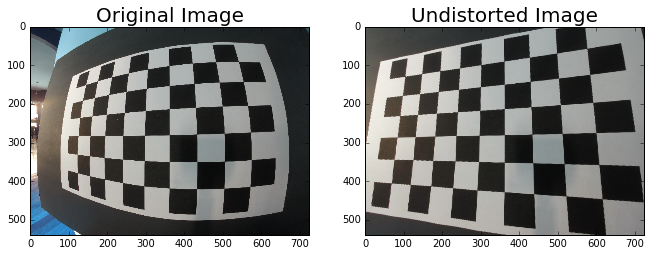

In [3]:
# Test undistortion on an image
#img = cv2.imread('camera_cal/calibration1.jpg')
img = cv2.imread('gopro720m/GOPR7222.JPG')
img = cv2.resize(img,(724,540))
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img_size = (img.shape[1], img.shape[0])
print (img_size)
# Do camera calibration given object points and image points
#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
#pickle.dump( dist_pickle, open( "camera_cal/724x540_cal_pickle.p", "wb" ) )
pickle.dump( dist_pickle, open( "gopro720m/724x540_cal_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)

(540, 724)
(array([[  59.5,  389. ]], dtype=float32), array([[ 220.,  536.]], dtype=float32), array([[ 579. ,  371.5]], dtype=float32), array([[ 379.,   98.]], dtype=float32))
False


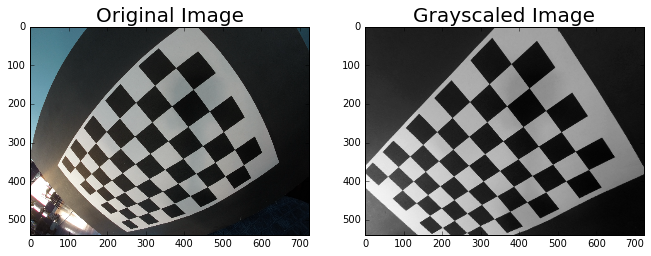

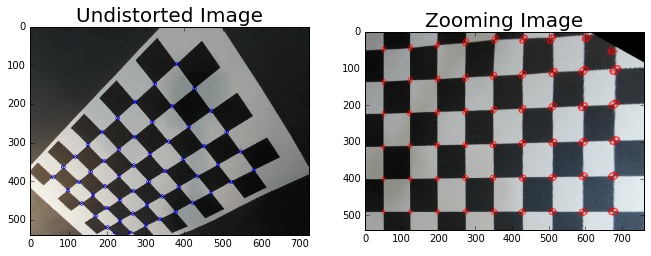

In [4]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
#dist_pickle = pickle.load( open( "camera_cal/720x540_cal_pickle.p", "rb" ) )
dist_pickle = pickle.load( open( "gopro720m/724x540_cal_pickle.p", "rb" ) )

mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
# Read in an image
#img = cv2.imread('camera_cal/calibration1.jpg')
img = cv2.imread('gopro720m/GOPR7232.JPG')
rows, cols, chs = img.shape
img = cv2.resize(img,(724,540))
undist = cv2.undistort(img, mtx, dist, None, mtx)
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
rows, cols, chs = img.shape
print(rows, cols)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(gray,cmap='gray')
ax2.set_title('Grayscaled Image', fontsize=20)

##
# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
print (corners[0], corners[-nx], corners[-1], corners[nx-1])
print (ret)
#print('Object point coordinates:', objp[-1], objp[-nx], objp[0], objp[nx-1])
#print ('Actual corners coordinates:', corners[-1], corners[-nx], corners[0], corners[nx-1])
# If found, add object points, image points
if ret == False:
    # Draw and display the corners
    cv2.drawChessboardCorners(undist, (nx,ny), corners, ret)
    
    offsetx = 50 # offset columns for dst points
    offsety = 50 # offset rows for dst points
    # Grab the image shape
    #img_size = (gray.shape[1], gray.shape[0])

    # For source points I'm grabbing the outer four detected corners
    src = np.float32([corners[-1], corners[-nx], corners[0], corners[nx-1]]) # 180 deg rotation
    #src = np.float32([corners[nx-1],corners[0], corners[-nx], corners[-1]])  # zero deg rotation
    
    dst = np.float32([[offsetx, offsety], [cols-offsetx, offsety], 
                                     [cols-offsetx, rows-offsety], 
                                     [offsetx, rows-offsety]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()80
    warped = cv2.warpPerspective(undist, M,(760, 540))


display = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.imshow(undist,cmap='gray')
ax1.set_title('Undistorted Image', fontsize=20)
ax2.imshow(display,cmap='gray')
ax2.set_title('Zooming Image', fontsize=20)


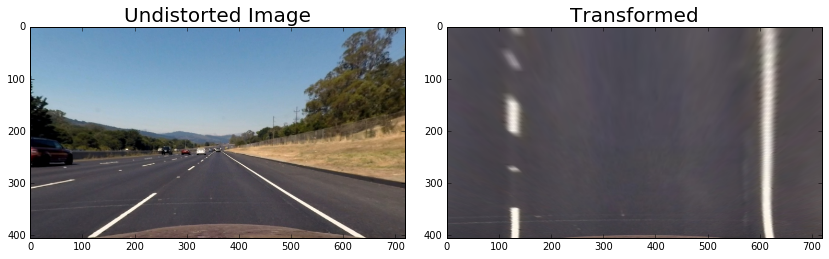

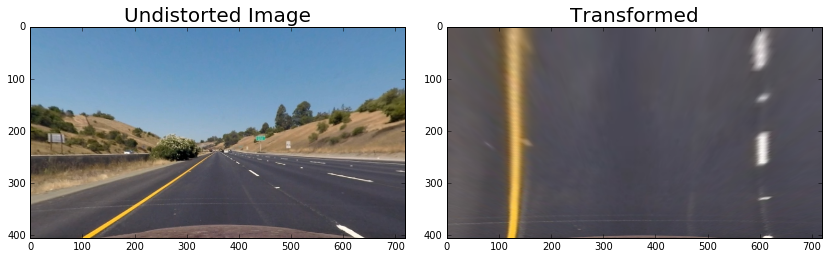

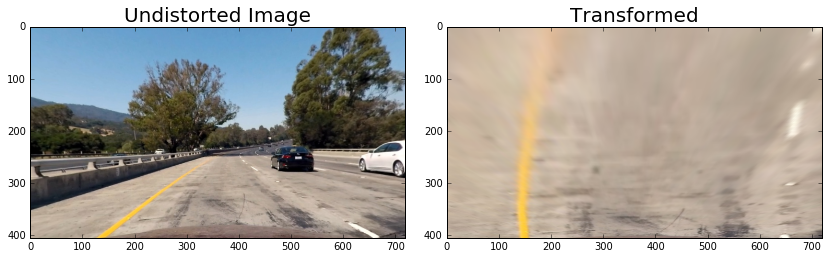

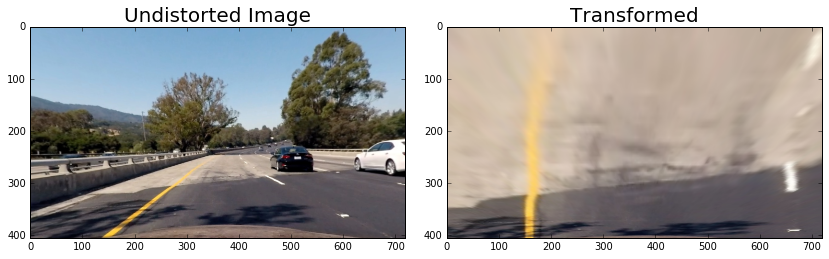

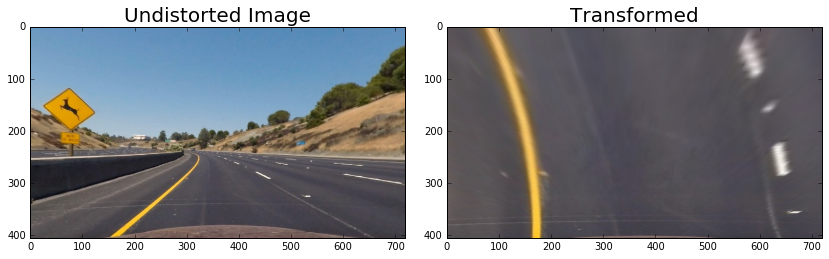

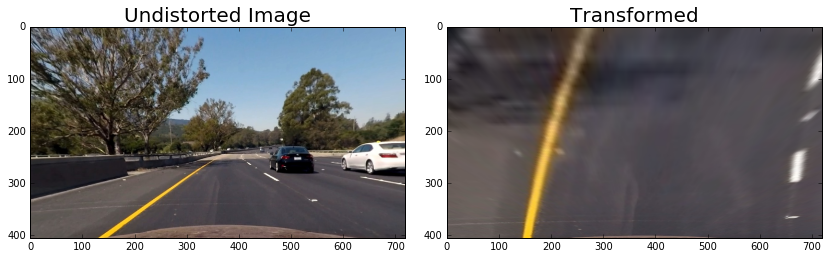

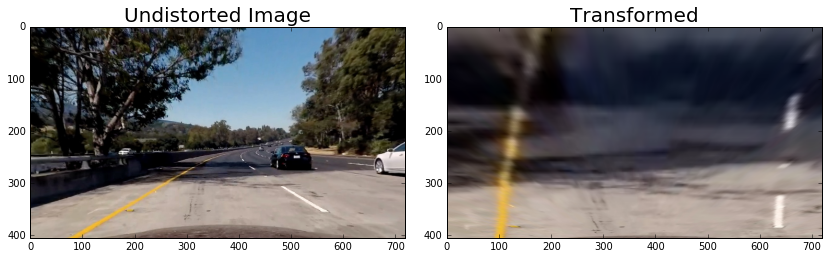

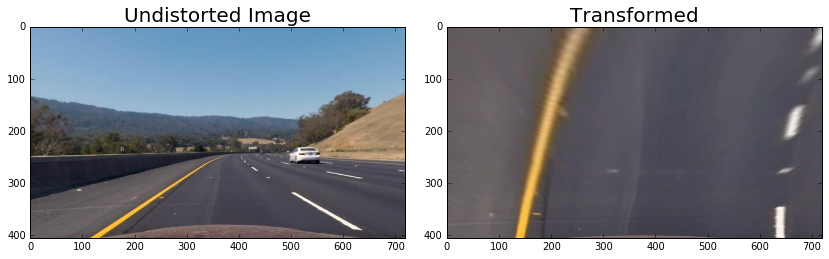

In [5]:
def perspective_transform(img, M):
    warped = cv2.warpPerspective(img, M, dsize = (img.shape[1],img.shape[0]), flags = cv2.INTER_LINEAR)
    return warped

apex, apey = 360, 258
offset_far = 50
offset_near = 10
src = np.float32([[int(apex-offset_far),apey],
                  [int(apex+offset_far),apey],
                  [int(0+offset_near),390],
                  [int(720-offset_near),390]])
dst = np.float32([[0,0],[720,0],[0,405],[720,405]])
M = cv2.getPerspectiveTransform(src, dst)

images = os.listdir('./test_images')  
for fname in images:
    fname = os.path.join('test_images',fname)
    img = mpimg.imread(fname)
    img = cv2.resize(img, (720, 405))
    img = cv2.undistort(img, mtx, dist, None, mtx)
    warped = perspective_transform(img, M)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Undistorted Image', fontsize=20)
    ax2.imshow(warped)
    ax2.set_title('Transformed', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)